# Light GBM

In [2]:
import pandas as pd
import time
import numpy as np
from sklearn.cross_validation import train_test_split
import lightgbm as lgb
import gc

In [3]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                      feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10,
                      categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric': metrics,
        'learning_rate': 0.01,
        # 'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric': metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params,
                     xgtrain,
                     valid_sets=[xgtrain, xgvalid],
                     valid_names=['train', 'valid'],
                     evals_result=evals_results,
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10,
                     feval=feval)

    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics + ":", evals_results['valid'][metrics][n_estimators - 1])

    return bst1


In [67]:
dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8',
    'click_id': 'uint32'
}
print('loading train data...')
train_df = pd.read_csv('/Users/mlx/Downloads/Document/talking_data/train_sample.csv', dtype=dtypes,
                       usecols=['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed'])

loading train data...


In [68]:
print('Extracting new time-related features...')
train_df['second'] = pd.to_datetime(train_df.click_time).dt.second.astype('uint8')
train_df['minute'] = pd.to_datetime(train_df.click_time).dt.minute.astype('uint8')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')
train_df['month'] = pd.to_datetime(train_df.click_time).dt.month.astype('uint8')

Extracting new time-related features...


In [69]:
total = len(train_df)
r_size = total // 4
val_df = train_df[:r_size]
train_df = train_df[r_size:]

In [76]:
target = 'is_attributed'
predictors = ['ip', 'app', 'device', 'os', 'channel', 'second', 'minute','hour', 'day', 'month']
categorical = ['ip', 'app', 'device', 'os', 'channel', 'second', 'minute','hour', 'day', 'month']
params = {
    'learning_rate': 0.15,
    # 'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 12,  # 2^max_depth - 1
    'max_depth': 4,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight': 99  # because training data is extremely unbalanced
}

bst = lgb_modelfit_nocv(params,
                        train_df,
                        val_df,
                        predictors,
                        target,
                        objective='binary',
                        metrics='auc',
                        early_stopping_rounds=100,
                        verbose_eval=True,
                        num_boost_round=500,
                        categorical_features=categorical)

preparing validation datasets
Training until validation scores don't improve for 100 rounds.
[10]	train's auc: 0.993087	valid's auc: 0.966497
[20]	train's auc: 0.997953	valid's auc: 0.95894


/Users/mlx/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/mlx/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[30]	train's auc: 0.998722	valid's auc: 0.953376
[40]	train's auc: 0.999206	valid's auc: 0.953392
[50]	train's auc: 0.999489	valid's auc: 0.940056
[60]	train's auc: 0.999701	valid's auc: 0.934006
[70]	train's auc: 0.999801	valid's auc: 0.928214
[80]	train's auc: 0.999902	valid's auc: 0.923562
[90]	train's auc: 0.999965	valid's auc: 0.914762
[100]	train's auc: 0.999985	valid's auc: 0.90927
[110]	train's auc: 0.999997	valid's auc: 0.905816
Early stopping, best iteration is:
[10]	train's auc: 0.993087	valid's auc: 0.966497

Model Report
n_estimators :  10
auc: 0.966497107426


In [77]:
test_df = pd.read_csv('/Users/mlx/Downloads/Document/talking_data/test.csv', dtype=dtypes,
                      usecols=['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id'])

In [79]:
test_df['second'] = pd.to_datetime(test_df.click_time).dt.second.astype('uint8')
test_df['minute'] = pd.to_datetime(test_df.click_time).dt.minute.astype('uint8')
test_df['hour'] = pd.to_datetime(test_df.click_time).dt.hour.astype('uint8')
test_df['day'] = pd.to_datetime(test_df.click_time).dt.day.astype('uint8')
test_df['month'] = pd.to_datetime(test_df.click_time).dt.month.astype('uint8')
test_df['click_id'] = test_df['click_id'].astype('int')

In [80]:
test_df['is_attributed'] = bst.predict(test_df[predictors])
test_df.to_csv('baseline_balanced99.csv', index=False)

In [82]:
test_df[['click_id', 'is_attributed']].to_csv('baseline_balanced99.csv', index=False)

In [83]:
train_df_2 = pd.read_csv('/Users/mlx/Downloads/Document/talking_data/train_sample.csv', dtype=dtypes,
                       usecols=['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed'])

In [84]:
r_size = 10
sample_idx = random.sample(range(100), r_size)

# Track Baseline

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

## Data Preparation

In [54]:
filename = 'train_sample.csv'
train_frame = pd.read_csv(filename)
del train_frame['attributed_time']
class_labels = train_frame['is_attributed'].values
del train_frame['is_attributed']
train_frame['second'] = pd.to_datetime(train_frame.click_time).dt.second.astype('uint8')
train_frame['minute'] = pd.to_datetime(train_frame.click_time).dt.minute.astype('uint8')
train_frame['hour'] = pd.to_datetime(train_frame.click_time).dt.hour.astype('uint8')
train_frame['day'] = pd.to_datetime(train_frame.click_time).dt.day.astype('uint8')
train_frame['month'] = pd.to_datetime(train_frame.click_time).dt.month.astype('uint8')
del train_frame['click_time']

## Models

In [84]:
def plotROCcurve(y_test, preds, savepath=None):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    import matplotlib.pyplot as plt
    fig = plt.figure()
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    if savepath is not None:
        fig.savefig(savepath, dpi = 100)
    
def get_models():
    lr = LogisticRegression(class_weight='balanced', random_state=42)
    rf = RandomForestClassifier(n_estimators=51, max_depth=5, min_samples_split=3, random_state=42, class_weight='balanced')
    grad = GradientBoostingClassifier(random_state=42)
    ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.15, random_state=42)
    bag = BaggingClassifier(n_estimators=51, random_state=42)
    extra = ExtraTreesClassifier(n_estimators=51, random_state=42, max_depth=5, class_weight='balanced')
    classifier_list = [lr, rf, grad, ada, bag, extra]
    classifier_name_list = ['Logistic Regression', 'Random Forests', 'Gradient Boosting', 'AdaBoost', 'Bagging', 'Extra Trees']
    return classifier_list, classifier_name_list

def evaluate_models(trained_model, trained_model_name, X_test, y_test):
    predicted_probs = None
    if 'predict_proba' in dir(trained_model):
        predicted_probs = trained_model.predict_proba(X_test)[:,1]

    predicted_values = trained_model.predict(X_test)

    print('---------- For Model Name : ', trained_model_name, ' ---------\n')
    if predicted_probs is not None:
        print('roc_auc_score: ', metrics.roc_auc_score(y_test, predicted_probs))
        plotROCcurve(y_test, predicted_probs, 'plots/' + trained_model_name + '.png')
    print('accuracy_score: ', metrics.accuracy_score(y_test, predicted_values))
    print('matthews_corrcoef: ', metrics.matthews_corrcoef(y_test, predicted_values))
    print('classification_report:\n', metrics.classification_report(y_test, predicted_values))
    print('-------------------------------------\n')
  

---------- For Model Name :  Logistic Regression  ---------

roc_auc_score:  0.877634045247


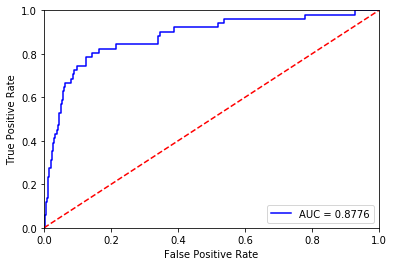

accuracy_score:  0.8196
matthews_corrcoef:  0.0840520916042
classification_report:
              precision    recall  f1-score   support

          0       1.00      0.82      0.90     19949
          1       0.01      0.82      0.02        51

avg / total       1.00      0.82      0.90     20000

-------------------------------------

---------- For Model Name :  Random Forests  ---------

roc_auc_score:  0.970126764426


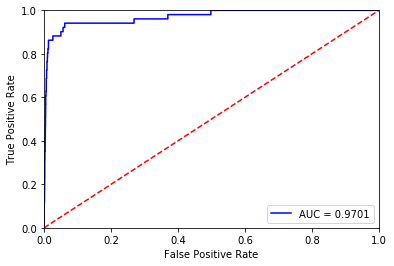

accuracy_score:  0.97245
matthews_corrcoef:  0.254853085853
classification_report:
              precision    recall  f1-score   support

          0       1.00      0.97      0.99     19949
          1       0.08      0.88      0.14        51

avg / total       1.00      0.97      0.98     20000

-------------------------------------

---------- For Model Name :  Gradient Boosting  ---------

roc_auc_score:  0.950974986215


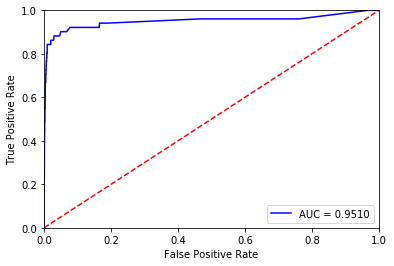

accuracy_score:  0.9974
matthews_corrcoef:  0.320056167451
classification_report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     19949
          1       0.48      0.22      0.30        51

avg / total       1.00      1.00      1.00     20000

-------------------------------------

---------- For Model Name :  AdaBoost  ---------

roc_auc_score:  0.963028271111


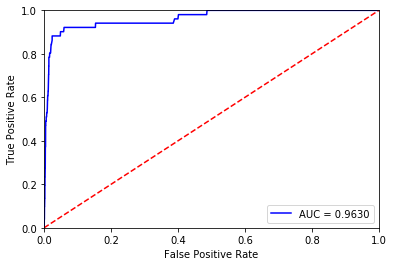

accuracy_score:  0.99735
matthews_corrcoef:  -0.000505645607243
classification_report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     19949
          1       0.00      0.00      0.00        51

avg / total       0.99      1.00      1.00     20000

-------------------------------------

---------- For Model Name :  Bagging  ---------

roc_auc_score:  0.896450163603


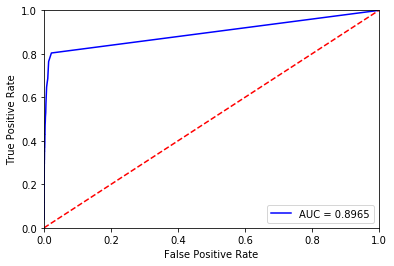

accuracy_score:  0.9975
matthews_corrcoef:  0.38889318247
classification_report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     19949
          1       0.52      0.29      0.38        51

avg / total       1.00      1.00      1.00     20000

-------------------------------------

---------- For Model Name :  Extra Trees  ---------

roc_auc_score:  0.882809006103


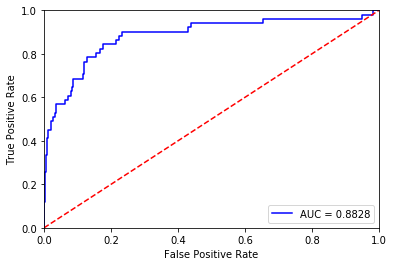

accuracy_score:  0.89005
matthews_corrcoef:  0.0926475763239
classification_report:
              precision    recall  f1-score   support

          0       1.00      0.89      0.94     19949
          1       0.02      0.69      0.03        51

avg / total       1.00      0.89      0.94     20000

-------------------------------------



In [85]:
X_train, X_test, y_train, y_test = train_test_split(train_frame.values, class_labels, test_size=0.2, random_state=42)
classifier_list, classifier_name_list = get_models()
for classifier, classifier_name in zip(classifier_list, classifier_name_list):
    classifier.fit(X_train, y_train)
    evaluate_models(classifier, classifier_name, X_test, y_test)